In [1]:
%matplotlib inline

Epoch [1000/5000], Loss: 1.3606
Epoch [2000/5000], Loss: 0.6107
Epoch [3000/5000], Loss: 0.3344
Epoch [4000/5000], Loss: 0.1957
Epoch [5000/5000], Loss: 0.1177


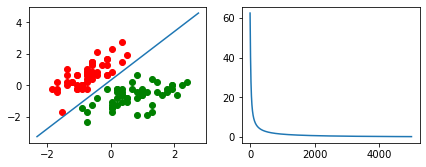

In [179]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO

input_size = 2
output_size = 1
batch_size = 100
half_batch_size = 50
num_epochs = 5000
log_time = num_epochs / 5
learning_rate = 0.03

fp = np.lib.DataSource().open('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
ds = np.genfromtxt(BytesIO(fp.read().encode()), delimiter=',', usecols=range(2), max_rows=batch_size)

X_train = (ds - np.mean(ds, axis=0)) / np.std(ds, axis=0)
y_train = np.zeros(100)
y_train[half_batch_size:] = 1

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.weight = self.linear.weight
        self.bias = self.linear.bias
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

model = Model()
criterion = nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_dict = []

for epoch in range(1, num_epochs + 1):
    prediction = model(torch.tensor(X_train).float())
    loss = criterion(prediction, torch.tensor(y_train).float().view(-1, 1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_dict.append(loss.item())
    if epoch % log_time == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, loss.item()))

x_min = X_train.min()
y_min = (-(model.weight[0][0] * x_min) - model.bias) / model.weight[0][1]
x_max = X_train.max()
y_max = (-(model.weight[0][0] * x_max) - model.bias) / model.weight[0][1]

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 'ro')
ax[0].plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 'go')
ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot(loss_dict)
plt.show()

Epoch [1000/5000], Loss: 0.2650
Epoch [2000/5000], Loss: 0.2467
Epoch [3000/5000], Loss: 0.2417
Epoch [4000/5000], Loss: 0.2400
Epoch [5000/5000], Loss: 0.2393


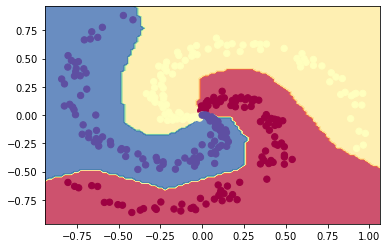

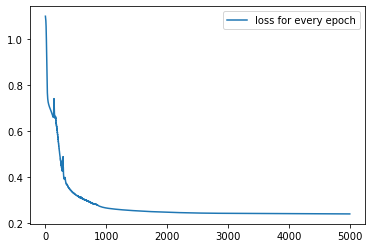

In [126]:
import numpy as np
import matplotlib.pyplot as plt
# np.random.seed(0)

reg = 1e-3
input_size = 2
batch_size = 100
num_classes = 3
num_neurons = 100
num_epochs = 5000
log_time = num_epochs / 5
learning_rate = 0.03
num_examples = batch_size * num_classes
loss_dict = []

w1 = learning_rate * np.random.randn(input_size, num_neurons)
w2 = learning_rate * np.random.randn(num_neurons, num_classes)
b1 = np.zeros((1, num_neurons))
b2 = np.zeros((1, num_classes))

X_train = np.zeros((batch_size * num_classes, input_size))
y_train = np.zeros(batch_size * num_classes, dtype='uint8')

for i in range(num_classes):
    radius = np.linspace(0, 1, batch_size)
    theta = np.linspace(i * 4, (i + 1) * 4, batch_size) + np.random.randn(batch_size) * 0.2
    X_train[range(batch_size * i, batch_size * (i + 1))] = np.c_[radius * np.sin(theta), radius * np.cos(theta)]
    y_train[range(batch_size * i, batch_size * (i + 1))] = i

for epoch in range(1, num_epochs + 1):
    # compute the class probabilities
    out1 = np.dot(X_train, w1) + b1
    out1 = np.maximum(0, out1) # ReLU
    out2 = np.dot(out1, w2) + b2
    probs = np.exp(out2) / np.sum(np.exp(out2), axis=1, keepdims=True)
  
    # compute regularization and average cross-entropy loss
    reg_loss = reg * (np.sum(w1 * w1) + np.sum(w2 * w2)) / 2 
    cross_entropy = np.sum(-np.log(probs[range(num_examples), y_train])) / num_examples
    
    loss = reg_loss + cross_entropy
    loss_dict.append(loss)
    if epoch % log_time == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, loss))

    # compute the gradient on out2
    grad2 = probs
    grad2[range(num_examples), y_train] -= 1
    grad2 /= num_examples
  
    # backprop into parameters w2 and b2
    dw2 = np.dot(out1.T, grad2)
    db2 = np.sum(grad2, axis=0, keepdims=True)
    
    # backprop into hidden layer
    grad1 = np.dot(grad2, w2.T)
    
    # backprop the ReLU non-linearity
    grad1[out1 <= 0] = 0
    
    # backprop into parameters w1 and b1
    dw1 = np.dot(X_train.T, grad1)
    db1 = np.sum(grad1, axis=0, keepdims=True)
  
    # update parameters
    w1 -= (dw1 + reg * w1)
    w2 -= (dw2 + reg * w2)
    b1 -= db1
    b2 -= db2

x_min, x_max = X_train[:, 0].min() - 0.1, X_train[:, 0].max() + 0.1
y_min, y_max = X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1
spacing = min(x_max - x_min, y_max - y_min) / 100
XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing), np.arange(y_min, y_max, spacing))

concatenation = np.c_[XX.ravel(), YY.ravel()]
out1 = np.dot(concatenation, w1) + b1
out1 = np.maximum(0, out1) # ReLU
out2 = np.dot(out1, w2) + b2
Z = np.argmax(out2, axis=1).reshape(XX.shape)

plt.contourf(XX, YY, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=40, cmap=plt.cm.Spectral)
plt.show()

plt.plot(loss_dict, label='loss for every epoch')
plt.legend()
plt.show()

[num of images, image x size, image y size]
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])

what type of data is it?
<class 'torch.Tensor'>
<class 'torch.Tensor'>

what is min and max values?
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)



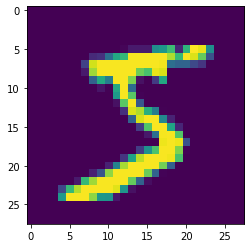

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

train = datasets.MNIST(
                    root = './', # where to download data set to
                    train = True, # If true, creates dataset from training.pt, otherwise from test.pt
                    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]), 
                    download = True) # convert data into tensor vs PIL image

test = datasets.MNIST(
                    root = './', 
                    train = False, 
                    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]),
                    download = True) # convert data into tensor vs PIL image

print("[num of images, image x size, image y size]")
print(train.data.shape)
print(test.data.shape)
print()
print("what type of data is it?")
print(type(train.data[0]))
print(type(test.data[0]))
print()
print("what is min and max values?")
print(torch.min(train.data[0]))
print(torch.max(train.data[0]))
print(torch.min(test.data[0]))
print(torch.max(test.data[0]))
print()
plt.imshow(train.data[0])

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

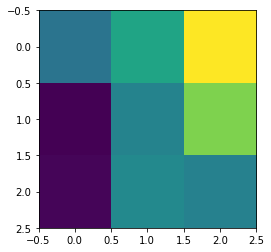

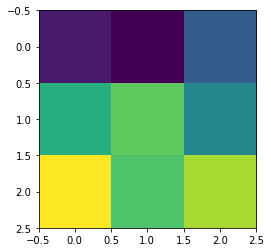

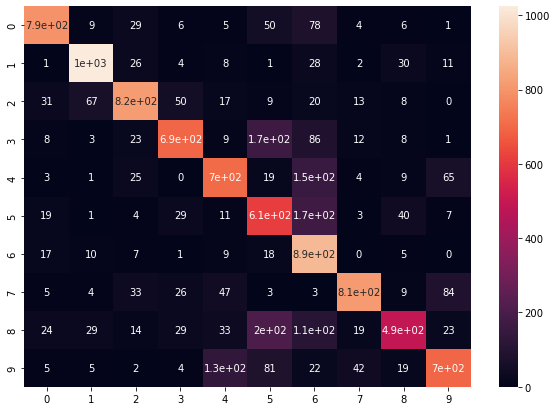

In [141]:
import torch
import numpy as np
import pandas as pd
import seaborn as sn
import torch.nn as nn
import torch.utils.data as tech
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

class CNN(nn.Module):
    def __init__(self, size, num_classes):
        super(CNN, self).__init__()
        # here is our "feature extraction" via convolutional layers 
        #   note: assume we got a single channel (grayscale) MNIST image of size 28x28x1
        #         first layer
        #             28x28x1 -> convolution (1 stride, 1 padd, 3x3 kernel, 2 kernels) -> 28x28x2
        #         pooling
        #             pool of 2x2 => 28x28 / 2 => 14x14 now (technically, 14x14x2 right!)
        #         second layer
        #             14x14x2 -> convolution (1 stride, 1 padd, 3x3 kernel, 4 kernels) -> 14x14x4
        #         pooling
        #             pool of 2x2 => 14x14 / 2 => 7x7 now (technically, 7x7x4 right!)
        self.extract = nn.Sequential(
                                    nn.Conv2d(in_channels=size, out_channels=2, kernel_size=3, stride=1, padding=1), 
                                    # in_channels = 1 for MNIST and 3 for RGB image
                                    # out_channels = 2 means 2 shared weights/features
                                    # kernel_size = 3 means a 3x3 size kernel
                                    # stride = 1 means move one pixel at a time in each dim
                                    # padding = adds one pixel of zeros to each side of each dim note,
                                    #           thats what keeps our spatial dims the same for a 3x3 kernel
                                    #           it also lets us process each location, even that border!!!
                                    nn.ReLU(inplace=True),
                                    # could also use torch.nn.Sigmoid or etc.
                                    # inplace means don't have to return a result, do it on the data
                                    # lets pool using a 2x2 region that is not overlapping
                                    nn.MaxPool2d(2),                                                  
                                    # lets do dropout with a small percentage/rate               
                                    nn.Dropout(0.1),
                                    # now lets make another layer of convolution, pooling, and drop out
                                    nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=1),
                                    # in_channels here needs to match out_channels above
                                    # lets use 4 filters 
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(2),
                                    nn.Dropout(0.1))
        # now we are going to make a simple MLP classifier on the end of our above features
        # take our 4 filters whose response fields are 7x7 to 12 neurons
        # map the 12 down to our number of output classes
        self.decimate = nn.Sequential(
                                    nn.Linear(4 * (7 * 7), 12),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.2),
                                    nn.Linear(12, num_classes))
    def forward(self, x):
        features = self.extract(x) # easy, pass input (x) to our "feature extraction" above
        features = features.view(features.size()[0], -1) # now, flatten 7x7x4 matrix to 1D array of 7*7*4 size
        myresult = self.decimate(features) # pass that to our MLP classifier, and done!!!
        return myresult

batch_size = 16
train_ld = tech.DataLoader(dataset=train, shuffle=True, batch_size=batch_size)
test_ld = tech.DataLoader(dataset=test, shuffle=False, batch_size=1) 

input_size = 1 # just 1 band for MNIST
num_classes = 10 # we have 10 classes in MNIST
model = CNN(input_size, num_classes)

learning_rate = 0.03
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
costfx = torch.nn.CrossEntropyLoss()

num_epochs = 1
for epoch in range(num_epochs):
    epoch_loss = []
    # lets grab a bunch of mini-batches from our training data set
    for batch_id, train_params in enumerate(tqdm(train_ld)):
        # samples are our images, labels are their class labels
        samples, labels = train_params
        # we need to convert these into tensors
        samples = samples.type('torch.FloatTensor') 
        labels = labels.type('torch.LongTensor')  
        # lets predict (forward pass)
        prediction = model(samples)
        # evaluate our error
        loss = costfx(prediction, labels)
        # keep track of that loss
        epoch_loss.append(loss.item())
        # zero our gradients
        optimizer.zero_grad()  
        # calc our gradients
        loss.backward()     
        # do our update
        optimizer.step()
    # keep track of loss over our batches
    epoch_loss = sum(epoch_loss)/len(epoch_loss)

for i in range(2):
    plt.figure()
    plt.imshow(np.squeeze(model.extract[0].weight[i,:,:,:].detach().numpy()))

confusionMatrix = torch.zeros((10, 10))
for sample, label in tqdm(test_ld):
    # what is its label?
    label = int(label.numpy())
    # print('Real label is {}'.format(label))
    # convert the sample (image) to a tensor for PyTorch
    sample = sample.type('torch.FloatTensor')
    # do forward pass (i.e., prediction)
    prediction = model(sample) 
    # take the largest output and return integer of which it was (make a classification decision)
    prediction = int(torch.argmax(prediction).numpy())
    # what was our prediction?
    # print(prediction)
    confusionMatrix[label, prediction] = confusionMatrix[label, prediction] + 1

df_cm = pd.DataFrame(np.asarray(confusionMatrix), index=[i for i in '0123456789'], columns=[i for i in '0123456789'])
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True)
plt.show()

Epoch [10/50], Loss: 0.1609
Epoch [20/50], Loss: 0.1442
Epoch [30/50], Loss: 0.1434
Epoch [40/50], Loss: 0.1375
Epoch [50/50], Loss: 0.1306
Accuracy: 95.57%


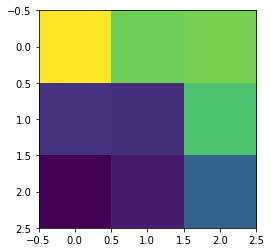

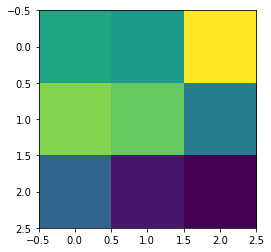

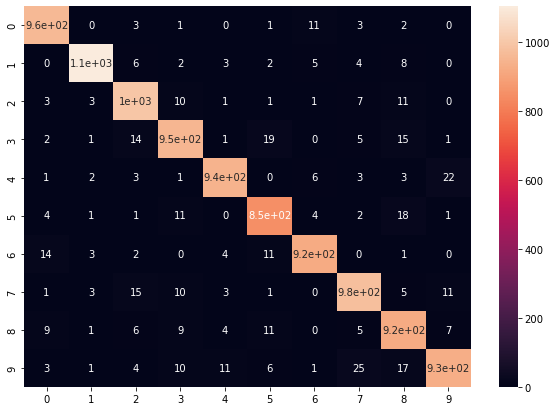

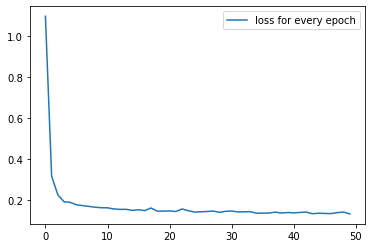

In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sn
import torch.nn as nn
import torch.utils.data as tech
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

input_size = 1
batch_size = 1000
num_classes = 10
num_neurons = 100
num_epochs = 50
log_time = num_epochs / 5
learning_rate = 0.03
loss_dict = []

train_ld = tech.DataLoader(dataset=train, shuffle=True, batch_size=batch_size)
test_ld = tech.DataLoader(dataset=test, shuffle=False, batch_size=1)

class CNN(nn.Module):
    def __init__(self, size, num_classes):
        super(CNN, self).__init__()
        self.extract = nn.Sequential(
                                    nn.Conv2d(in_channels=size, out_channels=2, kernel_size=3, stride=1, padding=1), 
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(2),                                                  
                                    nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(2),
                                    nn.Dropout(0.1))
        self.decimate = nn.Sequential(
                                    nn.Linear(4 * (7 * 7), num_neurons),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(0.2),
                                    nn.Linear(num_neurons, num_classes))
    def forward(self, x):
        features = self.extract(x)
        features = features.view(features.size()[0], -1)
        myresult = self.decimate(features)
        return myresult

model = CNN(input_size, num_classes)
costfx = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs + 1):
    epoch_loss = []
    for batch_id, train_params in enumerate(train_ld):
        samples, labels = train_params
        samples = samples.type('torch.FloatTensor') 
        labels = labels.type('torch.LongTensor')  
        prediction = model(samples)
        loss = costfx(prediction, labels)
        epoch_loss.append(loss.item())
        optimizer.zero_grad()  
        loss.backward()     
        optimizer.step()
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    loss_dict.append(epoch_loss)
    if epoch % log_time == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, epoch_loss))

for i in range(2):
    plt.figure()
    plt.imshow(np.squeeze(model.extract[0].weight[i,:,:,:].detach().numpy()))

correct = 0
confusionMatrix = torch.zeros((10, 10))
for sample, label in test_ld:
    label = int(label.numpy())
    sample = sample.type('torch.FloatTensor')
    prediction = model(sample) 
    prediction = int(torch.argmax(prediction).numpy())
    confusionMatrix[label, prediction] = confusionMatrix[label, prediction] + 1
    correct += int(label == prediction)
print('Accuracy: {:.2f}%'.format(correct / 100))

df_cm = pd.DataFrame(np.asarray(confusionMatrix), index=[i for i in '0123456789'], columns=[i for i in '0123456789'])
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True)
plt.show()

plt.figure()
plt.plot(loss_dict, label='loss for every epoch')
plt.legend()
plt.show()